In [9]:
from models.models import model1, bcm_sir #All the models we design for the test
# Import nevergrad
import nevergrad as ng
import pandas as pd 
import numpy as np
# Import our convenience wrapper
from estival.wrappers.nevergrad import optimize_model
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import Calibrate as cal #Runing the calibration process and gathering results


In [10]:
bcm_model_1 = bcm_sir()
model_1 = model1()

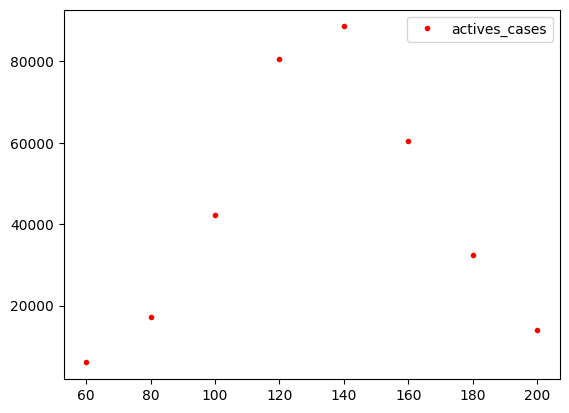

In [18]:

#Adding some noise
clean_target = bcm_model_1.targets["active_cases"].data
bcm_model_1.targets["active_cases"].data = clean_target * np.exp(np.random.normal(0.1,0.001,len(clean_target)))
# bcm_model_1.targets["active_cases"].data.plot(style='.', label="Noisy data")
clean_target.plot(style = '.',color = "red",label="actives_cases")
plt.legend()
plt.show()


In [ ]:
# TwoPointsDE is a good suggested default for some of our typical use cases
opt_class = ng.optimizers.TwoPointsDE
orunner = optimize_model(bcm_model_1, opt_class=opt_class)

In [ ]:
# Here we run the optimizer in a loop, inspecting the current best point at each iteration
# Using the loss information at each step can provide the basis for stopping conditions

for i in range(8):
    # Run the minimizer for a specified 'budget' (ie number of evaluations)
    rec = orunner.minimize(1000)
    # Print the loss (objective function value) of the current recommended parameters
    print(rec.loss)

In [ ]:
mle_params = rec.value[1]
print(mle_params)

In [ ]:
# Run the model against the parameter estimates
res_opt = bcm_model_1.run(mle_params)

In [ ]:
target = "active_cases"
pd.options.plotting.backend = "matplotlib" #To allow plotly graphic. Swich to "matplotlib" if facing some troubles while ploting

# You can access the targets from the BCM
bcm_model_1.targets[target].data.plot(style='.')
res_opt.derived_outputs[target].plot()

## MCMC Calibration

In [ ]:
sampler = pm.DEMetropolisZ
res_DEMz = cal.Single_analysis(sampler= sampler,
                               chains=4,
                               draws=5000,
                               tune=1000,
                               cores=4,
                               bcm_model=bcm_model_1,
                               )

In [ ]:
idata = res_DEMz["Trace"][0]

In [ ]:
az.plot_posterior?

In [ ]:
az.plot_posterior(idata,point_estimate='mode' )

In [ ]:
def fitting_test(idata, bcm, model):
    from estival.sampling.tools import likelihood_extras_for_samples
    likelihood_df = likelihood_extras_for_samples(idata.posterior, bcm)
    # likelihood_df = likelihood_extras_for_idata(idata, bcm)
    ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

    # Extract the parameters from the calibration samples
    map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()
    bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]
    # Run the model with these parameters
    model.run(map_params)
    # ...and plot some results
    return model.derived_outputs


In [ ]:
res = fitting_test(idata, bcm_model_1, model_1)

In [ ]:
df = pd.DataFrame({"DEMZ": res['active_cases']})
df.plot()
res_opt.derived_outputs[target].plot(label='Optimization')
bcm_model_1.targets["active_cases"].data.plot(style='.', label="target data")
plt.legend()
plt.show()
